![GMV](https://www.gmv.com/export/system/modules/com.gmv.teresa.site/resources/theme/img/logo_gmv.svg)  ![Apache Spark](http://spark.apache.org/images/spark-logo.png)

# KDD99 Supervised Learning II

# Apache Spark Initialization

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="SecurityDataScience")

In [2]:
%matplotlib inline

## 0. Libraries

In [3]:
import numpy as np
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import * 
sqlContext = SQLContext(sc)

## 1. Data Description

**Intrinsic attributes**

These attributes are extracted from the headers' area of the network packets.

Col|Feature name  | description |	type
---|--------------|-------------|------------
1  |duration 	  |length (number of seconds) of the connection |continuous
2  |protocol_type |type of the protocol, e.g. tcp, udp, etc. |discrete
3  |service 	  |network service on the destination, e.g., http, telnet, etc. |discrete
4  |flag 	      |normal or error status of the connection. The possible status are this: SF, S0, S1, S2, S3, OTH, REJ, RSTO, RSTOS0, SH, RSTRH, SHR 	|discrete 
5  |src_bytes 	  |number of data bytes from source to destination 	|continuous
6  |dst_bytes 	  |number of data bytes from destination to source 	|continuous
7  |land 	      |1 if connection is from/to the same host/port; 0 otherwise 	|discrete
8  |wrong_fragment|sum of bad checksum packets in a connection 	|continuous
9  |urgent 	      |number of urgent packets. Urgent packets are packets with the urgent bit activated 	|continuous


**Class attribute**

The 42nd attribute is the ***class_attack*** attribute, it indicates which type of connections is each instance: normal or which attack. The values it can take are the following: *anomaly, dict, dict_simple, eject, eject-fail, ffb, ffb_clear, format, format_clear, format-fail, ftp-write, guest, imap, land, load_clear, loadmodule, multihop, perl_clear, perlmagic, phf, rootkit, spy, syslog, teardrop, warez, warezclient, warezmaster, pod, back, ip- sweep, neptune, nmap, portsweep, satan, smurf and normal*.

** Categories of class attribute **


class_attack |Category
-------|--------------
smurf| dos
neptune| dos
back| dos
teardrop| dos
pod| dos
land| dos
normal|normal
satan|probe
ipsweep|probe
portsweep|probe
nmap|probe
warezclient|r2l
guess_passwd|r2l
warezmaster|r2l
imap|r2l
ftp_write|r2l
multihop|r2l
phf|r2l
spy|r2l
buffer_overflow|u2r
rootkit|u2r
loadmodule|u2r
perl|u2r

## 2. Load Data

In [4]:
textFileConn = sc.textFile('./data/KDD/KDDTrain+.txt', 4)


In [5]:
#Creating the schema

#we define the name of the columns

columnNames=["class_attack", "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
                 "wrong_fragment","urgent"]

In [6]:
#quick fields initialitation all for FloatType
connFields = [StructField(colName, FloatType(), True) for colName in columnNames]

In [7]:
#we proceed to modify the respective fields so that they reflect the correct data type:
connFields[0].dataType = StringType()
connFields[2].dataType = StringType()
connFields[3].dataType = StringType()
connFields[4].dataType = StringType()

In [8]:
# we can construct our schema, which we will use later below for building the data frame
connSchema = StructType(connFields)

In [9]:
#Parsing the file
def parseReg(p):
    return ( p[41]
            ,float(p[0])
            ,p[1], p[2], p[3] 
            ,float(p[4])
            ,float(p[5])
            ,float(p[6])
            ,float(p[7])
            ,float(p[8])
            )

In [10]:
connParsedFile = (textFileConn.map(lambda line: line.split(','))
                              .map(parseReg))

In [11]:
# We are now ready to build our data frame, using the connParsedFile RDD computed above and the schema 
# variable already calculated:
conn = sqlContext.createDataFrame(connParsedFile, connSchema)
conn.cache()

DataFrame[class_attack: string, duration: float, protocol_type: string, service: string, flag: string, src_bytes: float, dst_bytes: float, land: float, wrong_fragment: float, urgent: float]

In [12]:
conn.take(3)

[Row(class_attack='normal', duration=0.0, protocol_type='tcp', service='ftp_data', flag='SF', src_bytes=491.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0),
 Row(class_attack='normal', duration=0.0, protocol_type='udp', service='other', flag='SF', src_bytes=146.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0),
 Row(class_attack='neptune', duration=0.0, protocol_type='tcp', service='private', flag='S0', src_bytes=0.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0)]

In [13]:
conn.limit(4).toPandas()

,class_attack,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent
0,normal,0.0,tcp,ftp_data,SF,491.0,0.0,0.0,0.0,0.0
1,normal,0.0,udp,other,SF,146.0,0.0,0.0,0.0,0.0
2,neptune,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0
3,normal,0.0,tcp,http,SF,232.0,8153.0,0.0,0.0,0.0


In [14]:
#get all the distint values of class_attack
conn.select("class_attack").distinct().toPandas()

,class_attack
0,neptune
1,satan
2,nmap
3,portsweep
4,back
5,warezclient
6,guess_passwd
7,normal
8,rootkit
9,perl


## 3. Data Preparation

### 3.1 Encoding categorical features

In [15]:
from pyspark.sql import functions as F

In [16]:
def encodeCategorical(df, catName):
    #Encode the categorical variable in different columns foreach categories 
    #and the value is equal to 1 if the category is equal to column name and 0 otherwise. 
    #Finally drops the categorical variable
    
    categories = df.select(catName).distinct().toPandas()[catName]
    aux = df
    for c in categories:
        aux = aux.withColumn(c, F.when(df[catName] == c, 1).otherwise(0))
        
    return aux.drop(catName)

### Encoding *protocol_type*

In [17]:
conn.select("protocol_type").distinct().toPandas()

,protocol_type
0,tcp
1,udp
2,icmp


In [18]:
connEncoded = encodeCategorical(conn, "protocol_type")

In [19]:
connEncoded.limit(10).toPandas()

,class_attack,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp
0,normal,0.0,ftp_data,SF,491.0,0.0,0.0,0.0,0.0,1,0,0
1,normal,0.0,other,SF,146.0,0.0,0.0,0.0,0.0,0,1,0
2,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,normal,0.0,http,SF,232.0,8153.0,0.0,0.0,0.0,1,0,0
4,normal,0.0,http,SF,199.0,420.0,0.0,0.0,0.0,1,0,0
5,neptune,0.0,private,REJ,0.0,0.0,0.0,0.0,0.0,1,0,0
6,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
7,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
8,neptune,0.0,remote_job,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
9,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0


### Encoding *service*

In [20]:
connEncoded.select("service").distinct().toPandas()

,service
0,telnet
1,ftp
2,auth
3,iso_tsap
4,systat
5,name
6,sql_net
7,ntp_u
8,X11
9,pop_3


In [21]:
connEncoded = encodeCategorical(connEncoded, "service")

In [22]:
connEncoded.limit(10).toPandas()

,class_attack,duration,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,...,http_443,echo,netstat,remote_job,gopher,imap4,uucp,ssh,rje,bgp
0,normal,0.0,SF,491.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,normal,0.0,SF,146.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,normal,0.0,SF,232.0,8153.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,normal,0.0,SF,199.0,420.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,neptune,0.0,REJ,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
9,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Encoding *flag*

In [23]:
connEncoded.select("flag").distinct().toPandas()

,flag
0,RSTOS0
1,S3
2,SF
3,S0
4,OTH
5,REJ
6,RSTO
7,RSTR
8,SH
9,S2


In [24]:
connEncoded = encodeCategorical(connEncoded, "flag")

In [25]:
connEncoded.limit(10).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,normal,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,normal,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,normal,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,normal,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
9,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


###  Encoding *class_attack* (**label**) like Integers

In [26]:
connEncoded.select("class_attack").distinct().toPandas()

,class_attack
0,neptune
1,satan
2,nmap
3,portsweep
4,back
5,warezclient
6,guess_passwd
7,normal
8,rootkit
9,perl


In [27]:
categories = connEncoded.select("class_attack").distinct().toPandas()["class_attack"]

In [28]:
dictCategories = dict((v,int(k)) for (k,v) in categories.to_dict().items())

In [29]:
from pyspark.sql.functions import udf

In [30]:
def categoriesToInt(cat):
    return dictCategories[cat]

udfCategoriesToInt = udf(categoriesToInt, IntegerType())

In [31]:
connEncoded = connEncoded.withColumn("class_attack", udfCategoriesToInt("class_attack") )

In [32]:
connEncoded.limit(10).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,7,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,7,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,7,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


### 3.2 Input Normalization

http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.feature

In [33]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import DenseVector

In [34]:
connEncoded.limit(5).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,7,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,7,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,7,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [35]:
features = connEncoded.drop("class_attack")

In [36]:
features.limit(10).toPandas()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,telnet,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [37]:
stats = features.describe().toPandas()

In [38]:
minValue = np.array(stats[stats.summary=="min"].values[0][1:], float)

In [39]:
maxValue = np.array(stats[stats.summary=="max"].values[0][1:], float)

In [40]:
def minMaxScaler(minV, maxV, row):
    return DenseVector([(row[i]-minV[i])/(maxV[i]-minV[i]) for i in range(len(row))])
    

In [41]:
labeledData = connEncoded.rdd.map(lambda x: (x[0], minMaxScaler(minValue, maxValue, x[1:])))

In [42]:
labeledDataFrame = sqlContext.createDataFrame(labeledData, ["label", "features"])

In [43]:
labeledDataFrame.limit(5).toPandas()

,label,features
0,7,"[0.0, 3.5580640913867386e-07, 0.0, 0.0, 0.0, 0..."
1,7,"[0.0, 1.0579986911251809e-07, 0.0, 0.0, 0.0, 0..."
2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,7,"[0.0, 1.6812033995961777e-07, 6.22396149446560..."
4,7,"[0.0, 1.4420667091363767e-07, 3.20626006092917..."


### 3.3 Principal Component Analysis (PCA)

In [44]:
from pyspark.ml.feature import PCA

In [45]:
v = labeledDataFrame.limit(1).toPandas()["features"].values[0]
n_features = len(v.array)
print("Total number of features: %d" %n_features)

Total number of features: 90


In [46]:
def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input dataframe.
    """
    m = df.select(df['features']).rdd.map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).rdd.map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

In [47]:
from numpy.linalg import eigh

def pca(df, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).rdd.map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

In [48]:
%%time
comp, score, eigVals = pca(labeledDataFrame)

CPU times: user 20 ms, sys: 70 ms, total: 90 ms
Wall time: 28.1 s


In [49]:
varianceExplained = eigVals.cumsum()/eigVals.sum()

In [50]:
varianceExplained

array([0.29479691, 0.48615106, 0.56380045, 0.63536068, 0.69545384,
       0.75040061, 0.78239749, 0.80551199, 0.82220474, 0.83877532,
       0.85081663, 0.86054083, 0.86927623, 0.87724528, 0.88409997,
       0.88930303, 0.89344096, 0.89728165, 0.90089252, 0.90433219,
       0.90765466, 0.9108735 , 0.9140275 , 0.91716524, 0.92021357,
       0.92318417, 0.9261157 , 0.92901054, 0.93184957, 0.93457327,
       0.9371558 , 0.93969323, 0.94217673, 0.94462305, 0.94704482,
       0.94943382, 0.95178615, 0.9540581 , 0.95625777, 0.95843117,
       0.96059782, 0.96271828, 0.96481763, 0.96689013, 0.96891292,
       0.9708982 , 0.97286566, 0.97479129, 0.97666524, 0.97851848,
       0.98025443, 0.98191773, 0.98356335, 0.98515445, 0.98659116,
       0.9879796 , 0.98935899, 0.99071217, 0.99204842, 0.99323988,
       0.9943655 , 0.99518698, 0.9959188 , 0.99659168, 0.99709125,
       0.9974935 , 0.99786108, 0.99821679, 0.99855202, 0.99886945,
       0.99916855, 0.9994239 , 0.99963878, 0.99975124, 0.99982

In [51]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

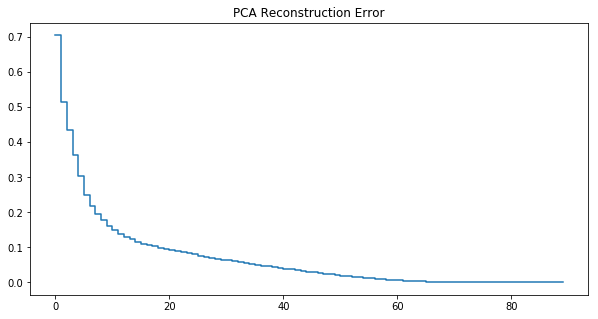

In [52]:
plt.plot(1 - varianceExplained, drawstyle = 'steps-post')
plt.title('PCA Reconstruction Error');

In [53]:
n_factors = ((1 - varianceExplained) > 0.10).sum()
print("Number of factors with 10% of reonstraction Error: ", n_factors)

Number of factors with 10% of reonstraction Error:  18


#### 3.2.1 Apache Spark Implementation

In [54]:
#Apache Spark API
pca = PCA(k = n_factors, inputCol="features", outputCol="pca_features")

In [55]:
%%time
pcaModel = pca.fit(labeledDataFrame)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 15.2 s


In [56]:
pcaDataFrame = pcaModel.transform(labeledDataFrame).drop("features")

In [57]:
pcaDataFrame.limit(10).toPandas()

,label,pca_features
0,7,"[0.4092095986138342, 0.5622203899840927, 0.260..."
1,7,"[0.8329281152434733, -0.47042369046325977, -0...."
2,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."
3,7,"[0.7088903082280972, 1.1814404139144128, -0.04..."
4,7,"[0.7088903082883997, 1.1814404139194503, -0.04..."
5,0,"[-0.6024765280183482, 0.4465725742426458, -1.0..."
6,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."
7,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."
8,0,"[-0.7843197336149492, 0.5127359042113997, 0.39..."
9,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."


## 4. Logistic Regression

### 4.1 Data Preparation to Logistic Regression

In [58]:
# Sampling with replacement with the 30% of data
connSample = pcaDataFrame.sample(withReplacement = True, fraction = 0.30).cache()

In [59]:
connSample.limit(10).toPandas()

,label,pca_features
0,7,"[0.4092095986138342, 0.5622203899840927, 0.260..."
1,7,"[0.8329281152434733, -0.47042369046325977, -0...."
2,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."
3,7,"[0.7088903082883997, 1.1814404139194503, -0.04..."
4,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."
5,0,"[-0.6024765280183482, 0.4465725742426458, -1.0..."
6,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."
7,7,"[0.7088903082730553, 1.1814404139182277, -0.04..."
8,5,"[0.40920959861592154, 0.562220389984151, 0.260..."
9,0,"[-0.7889080183075052, 0.5127239077243553, 0.39..."


In [60]:
#Modify class_attack catagory to binary category 
connLR = connSample.withColumn('label', when(connSample['label'] == 4, 0.0).otherwise(1.0))
connLR.cache()

DataFrame[label: double, pca_features: vector]

### 4.2 Training Logistic Regression

In [61]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

In [62]:
# Split the data into training and test sets (30% held out for testing)
(trainingDataLR, testDataLR) = connLR.randomSplit([0.7, 0.3])

In [63]:
lr = LogisticRegression(featuresCol="pca_features", labelCol= "label",
                        maxIter = 5, regParam = 0.1)

In [64]:
%%time
# Train model with trainingData.
lrModel = lr.fit(trainingDataLR)

CPU times: user 10 ms, sys: 10 ms, total: 20 ms
Wall time: 7.99 s


In [65]:
print("Logistic Regression coefficients:" , lrModel.coefficients)
print("Logistic Regression intercept:", lrModel.intercept)

Logistic Regression coefficients: [-0.0683777604886184,-0.12635004175940656,0.027167073554701687,-0.07443806800433322,-0.07022789692090418,0.04016925847774663,-0.005178191185266564,0.04096620917405075,0.06450515287939049,-0.15036189222638405,0.12887151540121178,-0.03281544861244942,0.031846002763262465,-0.019076099274025825,0.11342258341899951,-0.008177262907418267,0.0018124546030995055,0.0004383283357056519]
Logistic Regression intercept: 4.975732977625801


In [66]:
# Make predictions with testData.
predictionsLR = lrModel.transform(testDataLR)

In [67]:
# Select example rows to display.
predictionsLR.select("label", "prediction", "probability").limit(10).toPandas()

,label,prediction,probability
0,0.0,1.0,"[0.010108497167333697, 0.9898915028326662]"
1,0.0,1.0,"[0.010108497163370124, 0.98989150283663]"
2,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"
3,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"
4,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"
5,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"
6,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"
7,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"
8,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"
9,0.0,1.0,"[0.008098351650427429, 0.9919016483495725]"


In [68]:
# Compute raw scores on the test set
predictionAndLabelsLR = predictionsLR.select("prediction", "label").rdd

In [69]:
# Instantiate Basic Metrics object
basicMetricsLR = MulticlassMetrics(predictionAndLabelsLR)

In [70]:
print("Summary Stats")
print("Weighted Precision = %s" % basicMetricsLR.weightedPrecision)
print("Weigthed Recall = %s" % basicMetricsLR.weightedRecall)
print("Weighted F1 Score = %s" % basicMetricsLR.weightedFMeasure())
print("Confusion Matrix:")
pd.DataFrame(basicMetricsLR.confusionMatrix().toArray())

Summary Stats
Weighted Precision = 0.9861787079169493
Weigthed Recall = 0.993065308988764
Weighted F1 Score = 0.9896100277991532
Confusion Matrix:


,0,1
0,0.0,79.0
1,0.0,11313.0


In [71]:
# Instantiate Advanced Metrics object
advMetricsLR = BinaryClassificationMetrics(predictionAndLabelsLR)

In [72]:
# Area under precision-recall curve
print("Area under PR = %s" % advMetricsLR.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % advMetricsLR.areaUnderROC)

Area under PR = 0.993065308988764
Area under ROC = 0.5


### 4.3 Model selection via Cross Validation to LogisticRegresion

In [73]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [74]:
lr = LogisticRegression(featuresCol="pca_features", labelCol= "label")

In [75]:
grid = ParamGridBuilder().addGrid(lr.regParam, np.power(10.0, range(-3, 4, 1))) \
                         .addGrid(lr.maxIter, range(5, 21, 5)) \
                         .build()

In [76]:
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

In [77]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

In [78]:
%%time 
cvModel = cv.fit(connLR)

CPU times: user 3.56 s, sys: 1.28 s, total: 4.84 s
Wall time: 1min 52s


In [79]:
%%time
evaluator.evaluate(cvModel.transform(connLR))

CPU times: user 0 ns, sys: 20 ms, total: 20 ms
Wall time: 552 ms


0.9897628954294828

In [80]:
cvModel.bestModel

LogisticRegression_4c5394e362dd9efec259

-----

## 5. Linear Support Vector Machines (SVM)

### 5.1 Data Preparation to SVM

In [81]:
# Sampling with replacement with the 30% of data
connSample = pcaDataFrame.sample(withReplacement = True, fraction = 0.30).cache()

In [82]:
connSample.limit(10).toPandas()

,label,pca_features
0,7,"[0.7088903082280972, 1.1814404139144128, -0.04..."
1,0,"[-1.056085290267483, 0.35718532396757957, -0.1..."
2,0,"[-0.7888871833340537, 0.5126852770650479, 0.39..."
3,7,"[0.7088903082402789, 1.1814404139154318, -0.04..."
4,7,"[0.708890308210162, 1.1814404139128947, -0.048..."
5,7,"[0.708890308285972, 1.181440413919324, -0.0483..."
6,3,"[-0.6024765280183482, 0.4465725742426458, -1.0..."
7,7,"[0.7088903082721686, 1.1814404139181809, -0.04..."
8,0,"[-0.775163533319747, 0.5159570144865845, 0.510..."
9,0,"[-0.794269206496427, 0.5126451072384565, 0.402..."


In [83]:
#Modify class_attack catagory to binary category 
connSVN = connSample.withColumn('label', when(connSample['label'] == 4, 0.0).otherwise(1.0))\
          .rdd.map(lambda row: LabeledPoint(row[0], row[1:]))
connSVN.cache()

PythonRDD[5410] at RDD at PythonRDD.scala:49

### 5.2 Training SVN

In [84]:
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import Row

In [85]:
# Split the data into training and test sets (30% held out for testing)
(trainingDataSVM, testDataSVM) = connSVN.randomSplit([0.7, 0.3])

In [86]:
# Build the model
svm = SVMWithSGD.train(trainingDataSVM, iterations = 10)

In [87]:
# Evaluating the model on training data
labelsAndPredsSVM = testDataSVM.map(lambda p: Row(prediction = 1.0*svm.predict(p.features), label = p.label))

In [88]:
trainErr = labelsAndPredsSVM.filter(lambda r: r.label != r.prediction).count() / float(testDataSVM.count())
print("Training Error = " + str(trainErr))

Training Error = 0.007196770229945585


In [89]:
# Instantiate Basic Metrics object
basicMetricsSVM =  MulticlassMetrics(labelsAndPredsSVM)

In [90]:
print("Summary Stats")
print("Weighted Precision = %s" % basicMetricsSVM.weightedPrecision)
print("Weighted Recall = %s" % basicMetricsSVM.weightedRecall)
print("Weighted F1 Score = %s" % basicMetricsSVM.weightedFMeasure())
print("Confusion Matrix:")
pd.DataFrame(basicMetricsSVM.confusionMatrix().toArray())

Summary Stats
Weighted Precision = 0.9856582530418515
Weighted Recall = 0.9928032297700544
Weighted F1 Score = 0.9892178397920247
Confusion Matrix:


,0,1
0,0.0,82.0
1,0.0,11312.0
